In [1]:
import torch
import string
import time
import math
import random
import unicodedata
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, fc_hidden_dim):
    super().__init__()
    self.hidden_size = hidden_dim
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, fc_hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc_hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input, hidden):
    out, hidden = self.lstm(input.view(1, 1, -1), hidden)
    out = self.fc1(hidden[0])
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out.view(1, -1), hidden

  def init_hidden(self):
    return (torch.zeros(1, 1, self.hidden_size).to(device), torch.zeros(1, 1, self.hidden_size).to(device))

In [3]:
dataset = []

df = pd.read_csv('address_dataset.csv')
for index, row in df.iterrows():
  dataset.append((row['text'], row['label']))

random.shuffle(dataset)

In [4]:
all_letters = string.ascii_letters + " #.,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, 
# thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

def normalize(line):
    if type(line) != str:
      return " "
    line = line.replace(',', '')
    line = line.lower()
    return line

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    line = normalize(line)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
n_hidden = 128
n_hidden_2 = 64

lstm = LSTM(n_letters, n_hidden, n_hidden_2)
lstm.to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.0001)

def train(batch):
    optimizer.zero_grad()

    for b in batch:
      text, label = b
      text_tensor = lineToTensor(text)
      label_tensor = torch.tensor([[label]], dtype=torch.float).to(device)


      hidden = lstm.init_hidden()
      for i in range(text_tensor.size()[0]):
          output, hidden = lstm(text_tensor[i].to(device), hidden)

      loss = loss_fn(output.to(device), label_tensor)

      loss.backward()

    optimizer.step()


    return output, loss.item()

In [6]:
# Keep track of losses for plotting
all_losses = []
batches = 6000

lstm.train()

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

total_loss = 0
train_dataset = list(train_dataset)

for i in range(batches):
    batch = random.sample(train_dataset, 64)
    output, loss = train(batch)
    total_loss += loss

    if i % 250 == 0:
      avg_loss = total_loss / 250 if i != 0 else total_loss
      print("Loss: {}".format(avg_loss))
      all_losses.append(avg_loss)
      total_loss = 0


Loss: 0.7393369078636169
Loss: 0.6514319868683816
Loss: 0.42718880547024307
Loss: 0.40389058824640234
Loss: 0.3975895543542574
Loss: 0.34313902793056333
Loss: 0.37323609669983854
Loss: 0.3210836818691751
Loss: 0.31337956982752074
Loss: 0.35774919338517247
Loss: 0.23809909651301858
Loss: 0.19596880793968124
Loss: 0.20174430410038052
Loss: 0.13366474914424453
Loss: 0.1817590011989544
Loss: 0.1423165721869792
Loss: 0.1566551560374586
Loss: 0.13364807342615864
Loss: 0.08308641471415132
Loss: 0.09104247872057698
Loss: 0.11406096869220642
Loss: 0.09037867030942516
Loss: 0.06927300994560466
Loss: 0.05826734656913152


In [7]:
def evaluate(line_tensor):
    hidden = lstm.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

def test(test_inputs):
  correct = 0
  with torch.no_grad():
    for test in test_inputs:

      text, label = test
      output = evaluate(lineToTensor(text).to(device))

      pred = 1 if output.item() >= 0.5 else 0

      if pred == label:
        correct += 1
  
  print("Accuracy: {}".format(correct / len(test_dataset)))


test(test_dataset)

Accuracy: 0.9704660219501742


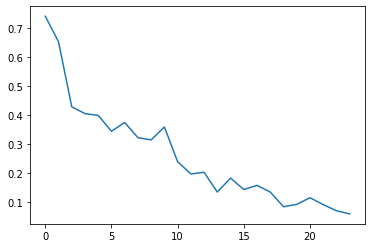

In [8]:
plt.figure()
plt.plot(all_losses)

In [9]:
def predict(input_line):
    print("{}".format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to(device))
        print(output.item())
        print()

print('Good Data')
print('='*20)
predict('1600 Pennsylvania Avenue, Washington DC 20500')
predict('10 3Rd Street Northwest Graysville AL 35073')
predict('12794 Columbia Ave. Yucaipa CA 92399')

print('Bad Data')
print('='*20)
predict('dfasdfa sfdasfds afas')
predict('Hey hey my my rock\'n roll can never die')
predict('1600, Washington DC 20500')
predict('1600 Pennsylvania Avenue, Washington DC')
predict('B107 15821 E 4th avenue Spokane Valley WA 36206')
predict('Pennsylvania Avenue, Washington 1600')
predict('P.o.box333 Sebastian TX 78594')
predict('1615 W. Harrison St.1615 W. Harrison St Freeport IL 61032')
predict('3325 11TH ST NW APT 8, Unit 8, Unit 8 Washington DC 20010')
predict('10446 briarcliff rd south jacksonville florida 32218 Springfield TN 37175')

Good Data
1600 Pennsylvania Avenue, Washington DC 20500
0.9939870834350586

10 3Rd Street Northwest Graysville AL 35073
0.9946637153625488

12794 Columbia Ave. Yucaipa CA 92399
0.9937145113945007

Bad Data
dfasdfa sfdasfds afas
1.8009475297731115e-06

Hey hey my my rock'n roll can never die
0.0038344301283359528

1600, Washington DC 20500
0.0007663015858270228

1600 Pennsylvania Avenue, Washington DC
8.691487892065197e-05

B107 15821 E 4th avenue Spokane Valley WA 36206
0.015284291468560696

Pennsylvania Avenue, Washington 1600
0.12631981074810028

P.o.box333 Sebastian TX 78594
0.050464946776628494

1615 W. Harrison St.1615 W. Harrison St Freeport IL 61032
0.0037117747124284506

3325 11TH ST NW APT 8, Unit 8, Unit 8 Washington DC 20010
0.0014020116068422794

10446 briarcliff rd south jacksonville florida 32218 Springfield TN 37175
0.005935974419116974



In [10]:
torch.save({
            'batch': 5000,
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'checkpoint.pt')

In [11]:
# checkpoint = torch.load('checkpoint.pt')
# lstm.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# batch = checkpoint['batch']
# loss = checkpoint['loss']